# MA3315: Introduction to Visual Computing - Paul Asquin 7 feb 2019
## Assignment 1

This assignment has two problems. 

Let us load the required libraries first. 

In [1]:
from __future__ import print_function
import cv2
import numpy as np
from scipy import ndimage
#import Image
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
%config IPCompleter.greedy=True

## 1. The Canny edge detector 

For the first problem, we will implement our own Canny edge detector. Recall that the Canny edge detector consists of the following steps:
* Smoothing the image using a Gaussian filter
* Computing the gradient of the image&mdash;magnitude and direction&mdash;using the Sobel operator
* Non-maximum suppression using the gradient's magnitude and direction
* Double thresholding
* Edge connectivity using hysterisis

#### 1.A Smoothing

This standard smoothing operation can be implemented using the `gaussian_filter` function found in `sklearn.ndimage`. 
Alternatively, you can use the following Gaussian filter: 

`G = np.array([[2, 4,  5,  2,  2],
               [4, 9,  12, 9,  4],
               [5, 12, 15, 12, 5],
               [4, 9,  12, 9,  4],
               [2, 4,  5,  4,  2]]) / 156;`

#### 1.B Gradients

Use the Sobel operators to compute $g_x$ and $g_y$. The magnitude and direction of the gradient can be computed as 
$\sqrt{g_x^2 + g_y^2}$, and $\arctan\left(\frac{g_y}{g_x}\right)$

#### 1.C Non-maximum suppression

We will take a simplistic approach to non-maximum suppression. First, we quantise the gradient directions into four values&mdash;$0$, $\frac{\pi}{4}$, $\frac{\pi}{2}$, and $\frac{3\pi}{4}$. Next, we suppress gradients at all points that are not greater than the two neighbours found when moving in the direction perpendicular to the edge.

#### 1.D Doule thresholding

Double thresholding can be implemented by fixing two thresholds, `lo` and `hi`. Accordingly, we will have two *levels* of gradient magnitudes&mdash;*weak* and *strong*. Pixels where the magnitude of the gradient is greater than high will be designated *strong* points, while those where it lies between `lo` and `high` will be designated *weak*. 

#### 1.E Edge connectivity

Finally, we decide on edge connectivity as follows: 
* All pixels with strong gradients belong to edges, termed *definite edges*.
* All pixels with weak gradients belong to edges only if they are connected to definite edges. 

Given below is a template for the Canny edge detector. Your task is to complete this function, and write any supporting functions necessary. You are, of course, free to diverge from this template, if you so wish. 

## Note
Look at ~~Depth first search~~ breadth-first search and Queues for the graph using A, B, C, D, E, F, G vertices

In [2]:
from scipy import signal

def gaussian_smoothing(img):
    '''perform gaussian filtering'''
    G = np.array([[2, 4,  5,  2,  2],
                  [4, 9,  12, 9,  4],
                  [5, 12, 15, 12, 5],
                  [4, 9,  12, 9,  4],
                  [2, 4,  5,  4,  2]]) / 156;
    img_smooth = signal.convolve2d(img, G, mode="same")
    return img_smooth

def gradient(smoothed):
    ''' compute magnitude and direction for gradient'''
    
    # Compute derivate
    mask = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    gx = signal.convolve2d(img, mask, mode="same")
    gy = signal.convolve2d(img, mask.T, mode="same")
    
    # Compute magnitude and direction
    magnitude = np.sqrt(gx**2 + gy**2)
    direction = np.arctan2(gy, gx)
    return magnitude, direction


def non_maximum_suppression(g_magnitude, g_direction):
    # New matrix to home new magnitude matrix with maximums
    g_magnitude_max = np.zeros(g_magnitude.shape)
    
    # We create a new matrix with a 1 size padding to simplify area maximum check (issues with borders otherwise)
    g_magnitude_pad = np.pad(g_magnitude, 1, mode='constant')
    
    # Cadran, possible directions discretisation
    disc_directions = [0, np.pi/4, np.pi/2, np.pi*3/4, np.pi, np.pi*(-1+1/4), np.pi*(-1+1/2), np.pi*(-1+3/4), -np.pi]
    #                  0    1         2         3       4         5              6                7              8
    
    # Exploring the directions
    height, width = g_direction.shape
    
    for x in range(height):
        for y in range(width):
            # Computing best match in discretise directions
            distance_to_directions = np.abs(disc_directions - g_direction[x, y])
            id_best_direction = np.argmin(distance_to_directions)
            
            delta_x = 0
            delta_y = 0
            regular_crawl = 1
            if id_best_direction in [0, 4, 8]:
                # If angle == 0, pi, -pi, we look up and down
                delta_x, delta_y, regular_crawl = 0, 1, 1
            elif id_best_direction in [1, 5]:
                # if angle == pi/4, pi(-1+1/4), we look up-left, down-right
                delta_x, delta_y, regular_crawl = 1, 1, 1
            elif id_best_direction in [2, 6]:
                # if angle == pi/2, pi(-1+1/2), we look left, right
                delta_x, delta_y, regular_crawl = 1, 0, 1
            else:
                # if angle == 3pi/4, pi(-1+3/4), we look up-right, down-left, thus we inverse regular crawling
                delta_x, delta_y, regular_crawl = 1, 1, -1
                
            if g_magnitude[x, y] >= max(g_magnitude_pad[x+1+delta_x, y+1+delta_y*regular_crawl],
                                        g_magnitude_pad[x+1-delta_x, y+1-delta_y*regular_crawl]):
                # If local maximum, we assign the value
                g_magnitude_max[x, y] = g_magnitude[x, y]
    
    return g_magnitude_max
    

def double_thresholding(g_max, lo, hi):
    # If greater than hi, assign 2, if not but greater than lo, assign 1, else assign 0 using a np.where ternary condition
    threshold = np.where(g_max > hi, 'strong', np.where(g_max > lo, 'weak', 'null'))
    return threshold


def connectivity(thresh_img):
    edge = np.zeros(thresh_img.shape)
    thresh_img_pad = np.pad(thresh_img, 1, mode='constant')
    
    height, width = thresh_img.shape
    for x in range(height):
        for y in range(width):
            if thresh_img[x, y] == 'strong':
                edge[x, y] = 1
            elif thresh_img[x, y] == 'weak':
                # Searching neighbours in a cross (we don't care of going back to the center of the cross,
                # we already know it's labelled 'weak')
                neighbours = []
                for i in [-1, 0, 1]:
                    for j in [-1, 0, 1]:
                        neighbours.append(thresh_img_pad[x+1+i, y+1+j])
                if 'strong' in neighbours:
                    # If one of the neighbour is strong, we activate the pixel as edge
                    edge[x, y] = 1
    return edge

def canny_edge_detector(img, thresh_lo=0.1, thresh_hi=0.2):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = gaussian_smoothing(img)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)

    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    # Return the result
    return edge_img

Now test the code on a sample image&mdash;

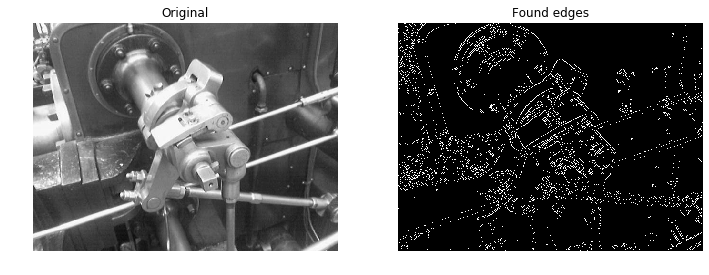

In [3]:
img   = cv2.imread('valve.png')
img   = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255

edges = canny_edge_detector(img, thresh_lo=0.15, thresh_hi=0.3)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(img, cmap="gray")
plt.axis('off')
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(edges, cmap="gray")
plt.axis('off')
plt.title('Found edges')

plt.show()

## 2. Stitching two images

For this problem, you are given two images&mdash;`left.png` and `right.png`, which were extracted from a bigger image. All we know is that `left.png` lies to the left and a bit above of `right.png`, and there is an overlapping region between the two. Your task will be to *stitch* these images together so that you can form a bigger image out of two smaller images. 

Let us load the images first.

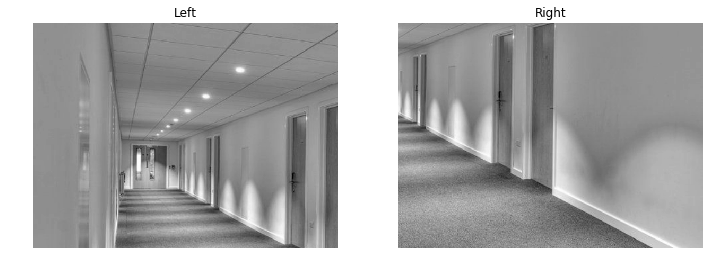

In [4]:
left_img   = cv2.imread('left.png')
left_img   = cv2.cvtColor(left_img, cv2.COLOR_RGB2GRAY)

right_img  = cv2.imread('right.png')
right_img  = cv2.cvtColor(right_img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.imshow(left_img, cmap='gray')
plt.axis('off')
plt.title('Left')

plt.subplot(1, 2, 2)
plt.imshow(right_img, cmap='gray')
plt.axis('off')
plt.title('Right')

plt.show()

We will try to solve this problem using the Harris corner detector and the RANdom SAmple Consensus (RANSAC) algorithm. 

The steps are the following&mdash;
* Find corner points in both images using the Harris corner detector. 
* Choose a random pair of points&mdash;one from the left image, and the other from the right. 
* We will assume that this pair represents the same location in the scene in both images. This gives a translation vector, so the we can superimpose this point in the right image onto the left image.
* The translation gives us an overlapping region, which can be given a similarity score. 
* If we keep choosing this pair of points randomly, we can keep improving our similarity score until we have found the best match. 

Your task now is the complete the following code. 

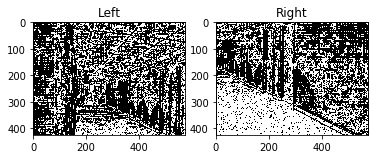

lowest mean squared error: 0.323125
transformation vector: (163, 298)
merged shape (588, 873)
Left above right


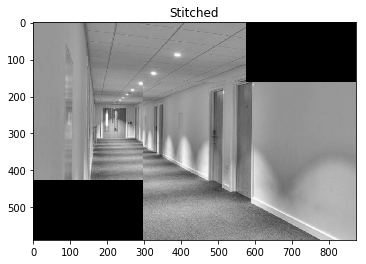

In [8]:
import random

def harris_corner_detector(img, pad, threshold):
    '''Find Harris corners
    param:
    pad (default: 1): select a window size for harris search
    threshold (default: 0.2): separate corners from edge
    '''
    img = img / 255
    corners = np.zeros(img.shape)
    
    # Compute derivate
    mask = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    dx = signal.convolve2d(img, mask, mode="same")
    dy = signal.convolve2d(img, mask.T, mode="same")
    
    Ixx = dx**2
    Iyy = dy**2
    Ixy = dy*dx
    
    # Searching corners in image
    height, width = img.shape
    
    for x in range(pad, height-pad):
        for y in range(pad, width-pad):
            # Compute sum of square-windows
            Sxx = np.sum(Ixx[x-pad:x+pad, y-pad:y+pad])
            Syy = np.sum(Iyy[x-pad:x+pad, y-pad:y+pad])
            Sxy = np.sum(Ixy[x-pad:x+pad, y-pad:y+pad])
            
            # Compute harris response
            det = Sxx * Syy - Sxy**2
            trace = Sxx + Syy
            r = det - threshold*trace**2
            if r > 0:
                # We have a corner
                corners[x, y] = 1
    return corners

def find_random_pair(corners_left, corners_right):
    '''return random pair of corners'''
    
    height_left, width_left = corners_left.shape
    c_left = [
        random.choice(range(height_left)),
        random.choice(range(width_left))
    ]
    
    height_right, width_right = corners_right.shape
    c_right = [
        random.choice(range(height_right)),
        random.choice(range(width_right))
    ]
    
    return(c_left, c_right)


def find_translation_vector(c_left, c_right):
    '''translation from right image to left image'''
    vector = [
        c_left[0] - c_right[0],
        c_left[1] - c_right[1]
    ]
    return vector


def compute_error(corners_left, c_left, corners_right, c_right, window):
    
    # Extract points
    x_left, y_left = c_left
    x_right, y_right = c_right
    
    if min(x_left-window, y_left-window, x_right-window, y_right-window) < 0 \
    or x_left+window > corners_left.shape[0] \
    or x_right+window > corners_right.shape[0] \
    or y_left+window > corners_left.shape[1] \
    or y_right+window > corners_right.shape[1]:
        # We are going out of borders
        return np.inf
    
    else:
        window_left = corners_left[
            x_left-window : x_left+window,
            y_left-window : y_left+window]

        window_right = corners_right[
            x_right-window : x_right+window,
            y_right-window : y_right+window]
        
        if np.sum(window_left) == 0 or np.sum(window_right) == 0:
            # if no point in window
            return np.inf
        
        # Calculating error using mean of squared error
        error = np.square(window_left - window_right).mean()
    return error
    

def merge_images(left, right, best_trans):
    
    # Compute shape of merged image
    merged_shape = np.array(left.shape) + np.array(best_trans)
    merged = np.zeros(merged_shape)
    
    print("merged shape", tuple(merged_shape))
    height, width = merged_shape
    
    # Transformation from right to left
    x_trans, y_trans = best_trans
    
    if y_trans > 0:
        print("Left above right")
        # Image left is above right, thus left have low x (and low y)
        for x in range(left.shape[0]):
            for y in range(left.shape[1]):
                merged[x, y] = left[x, y]
        
        # Image right is under left, thus right have high x  and high y
        for x in range(right.shape[0]):
            for y in range(right.shape[1]):
                merged[x + merged_shape[0] - right.shape[0], y + merged_shape[1] - right.shape[1]] = right[x, y]
    else:
        print("Right above left")
        # Image right is above left, thus left have high x (and low y)
        for x in range(left.shape[0]):
            for y in range(left.shape[1]):
                merged[x + merged_shape[0] - left.shape[0], y] = left[x, y]
        
        # right have high y and low x
        for x in range(right.shape[0]):
            for y in range(right.shape[1]):
                merged[x, y + merged_shape[1] - right.shape[1]] = right[x, y]
        
    return merged

def stitch_images(left, right, max_tries, pad, threshold, error_window):
    # Find corner points
    corners_left  = harris_corner_detector(left, pad, threshold)
    corners_right = harris_corner_detector(right, pad, threshold)
    
    best_error = 255*left.shape[0]*left.shape[1]
    best_trans = None
    
    for n_try in range(max_tries):
        # Choose two points randomly
        c_left, c_right  = find_random_pair(corners_left, corners_right)
        
        # Get translation vector
        x_trans, y_trans = find_translation_vector(c_left, c_right)
        
        # Compute resulting error. 
        this_error       = compute_error(corners_left, c_left, corners_right, c_right, error_window)
        if this_error < best_error:
            best_error   = this_error
            best_trans   = x_trans, y_trans
            best_c_left, best_c_right = c_left, c_right
    print("lowest mean squared error:",best_error)
    print("transformation vector:", best_trans)
    
    stitched_image = merge_images(left, right, best_trans)
    return stitched_image

CHECK_HARRIS = True

# HARRIS PARAMETERS
PAD = 1
THRESHOLD = 0.035

# ERROR ESTIMATOR
ERROR_WINDOW = 100

if CHECK_HARRIS:
    # Checking harris
    plt.subplot(1, 2, 1)
    corners_left  = harris_corner_detector(left_img, PAD, THRESHOLD)
    plt.imshow(corners_left, cmap='gray')
    #plt.axis('off')
    plt.title('Left')

    plt.subplot(1, 2, 2)
    corners_right  = harris_corner_detector(right_img, PAD, THRESHOLD)
    plt.imshow(corners_right, cmap='gray')
    #plt.axis('off')
    plt.title('Right')

    plt.show()

# Stitching
stitch_img = stitch_images(left_img, right_img, max_tries=100000, pad=PAD, threshold=THRESHOLD, error_window=ERROR_WINDOW)

plt.imshow(stitch_img, cmap='gray')
# plt.axis('off')
plt.title("Stitched")
plt.show()

**Remark.** Note that in this simplified problem setting, we assumed only translations along $x-$ and $y-$axes. However, in a real-world scenario, we can expect any affine transformation and/or viewpoint differences between the two images. This means we can no longer decide correspondences using only one pair of points. Can you think of a strategy that can be employed in such a scenario? 

With this senario, we could think of testing random orientation possibilities and use the mean square method to  converge toward the best orientation.  
We could also try to perform a Hough Tranform to identify mains perspectives in the images and fit the pictures to it.